# Permutation score - Dataset comparison

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import joypy
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.gridspec import GridSpec

import scanpy as sc
import scvelo as scv
import scvi
from anndata import AnnData
from scvelo.plotting.simulation import compute_dynamics
from velovi import preprocess_data, VELOVI

sys.path.append("../..")
from utils.unraveled import simulate_burst_model
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'permutation', exist_ok=True)

## Function definitions

In [5]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

## Data loading

In [8]:
nCells = 3000
nGenes = 100
T = 20
nclus= 10
seed = 42
meta = nCells,nGenes,T,nclus,seed

simdata = simulate_burst_model(*meta)

def sim_to_adata(simdata, meta):
    X, cell_types, tvec, K, g_true, b_true = simdata
    nCells, nGenes, T, tau, topo = meta
    adata = AnnData(X[1, :, :])
    adata.layers["spliced"] = X[1, :, :]
    adata.layers["unspliced"] = X[0, :, :]
    adata.layers["ambiguous"] = np.zeros_like(X[1, :, :])
    # br = np.zeros(nCells,dtype=bool)
    # br[branch_cells]=True
    adata.obs["time"] = tvec
    adata.obs["celltype"] = np.array(cell_types).astype(str)
    adata.var["gamma"] = g_true
    adata.var["beta"] = b_true
    adata.var["Gene"] = np.asarray([str(i) for i in range(len(g_true))])
    # adata.uns["K"]=K
    n_K = K.shape[1]
    for i in range(n_K):
        adata.var["k" + str(i)] = K[:, i]
    
    return adata

adata = sim_to_adata(simdata, meta)

In [9]:
adatas = [
    scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad"),
    scv.datasets.dentategyrus_lamanno(DATA_DIR / "dentategyrus" / "DentateGyrus.loom"),
    scv.datasets.forebrain(DATA_DIR / "forebrain" / "hgForebrainGlut.loom"),
    sc.read(DATA_DIR / 'pbmc' / 'pbmc_10k.h5ad'),
    sc.read(DATA_DIR / 'retina' / 'mouse_retina.h5ad'),
    sc.read(DATA_DIR / "old_brain" / "old_brain.h5ad"),
    sc.read(DATA_DIR / "pfc" / "pfc.h5ad"),
    sc.read(DATA_DIR / "spermatogenesis" / "spermatogenesis.h5ad"),
    adata,
]
del adata

names = ["Pancreas", "Hippocampus", "Forebrain", 'PBMC', 'Mouse retina', 'Old brain', 'PFC', 'Spermatogenesis', 'Simulated']
labels_keys = ["clusters", "clusters", "Clusters", "celltype", "Clusters", 'clusters_coarse', 'clusters', 'clusters', "celltype"]

In [10]:
adatas[3] = adatas[3][adatas[3].obs['celltype'].isin(['CD4 T', 'CD8 T']), :].copy()

## Data preprocessing

In [11]:
for adata_id, a in enumerate(adatas):
    scv.pp.filter_and_normalize(a, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(a, n_pcs=30, n_neighbors=30)
    
    scaler = MinMaxScaler()
    a.layers["Mu"] = scaler.fit_transform(a.layers["Mu"])

    scaler = MinMaxScaler()
    a.layers["Ms"] = scaler.fit_transform(a.layers["Ms"])

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 26764 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2

## Model training

In [12]:
for i, a in enumerate(adatas):
    # don't mess with pancreas, it changes colors
    if i > 0:
        a.obs[labels_keys[i]] = pd.Categorical(a.obs[labels_keys[i]].values.astype(str))

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 465/500:  93%|█████████▎| 465/500 [02:12<00:09,  3.52it/s, loss=-3.89e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3726.740. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 171/500:  34%|███▍      | 171/500 [03:39<07:01,  1.28s/it, loss=-6.12e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -5984.164. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 414/500:  83%|████████▎ | 414/500 [01:01<00:12,  6.70it/s, loss=-2.29e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2287.466. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 258/500:  52%|█████▏    | 258/500 [01:31<01:25,  2.83it/s, loss=-2.87e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2833.078. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 451/500:  90%|█████████ | 451/500 [01:35<00:10,  4.70it/s, loss=-3.42e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3334.192. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s, loss=-7.24e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [00:56<00:00,  8.89it/s, loss=-5.69e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:28<00:00,  5.64it/s, loss=-4.87e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 368/500:  74%|███████▎  | 368/500 [01:30<00:32,  4.07it/s, loss=-123, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -115.745. Signaling Trainer to stop.


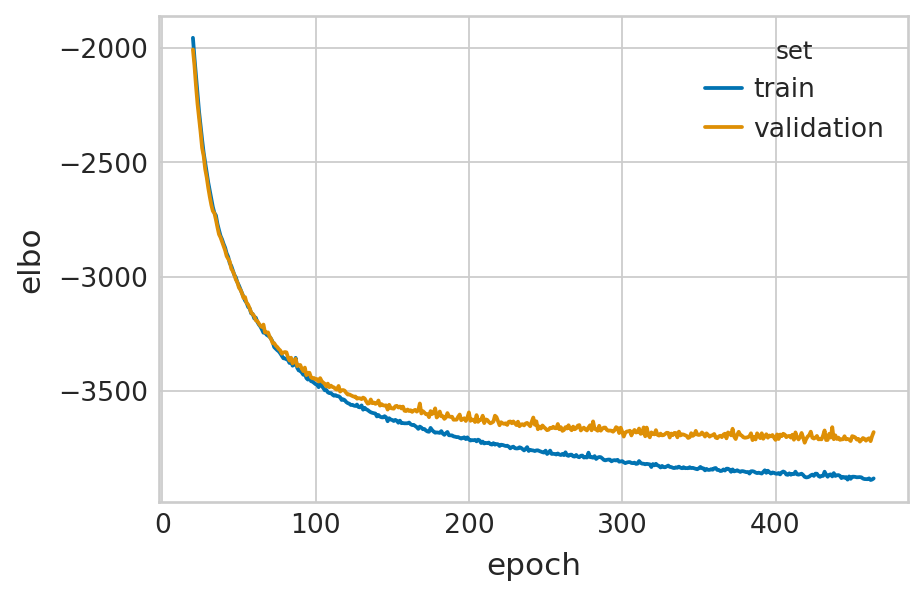

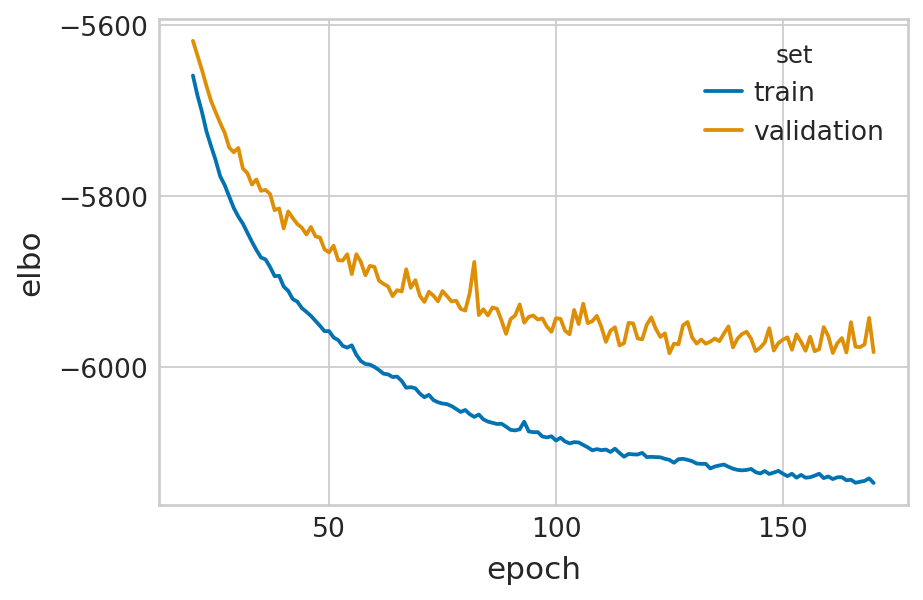

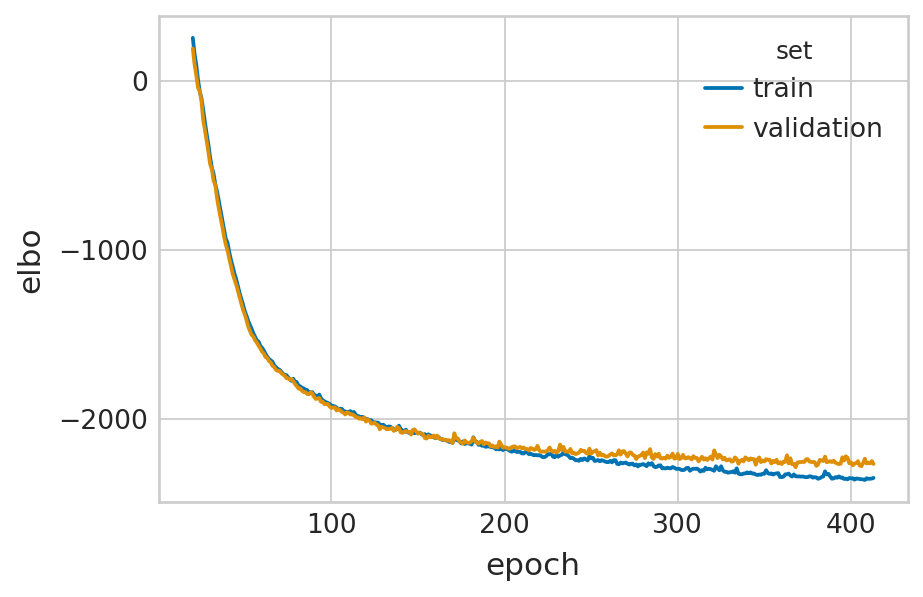

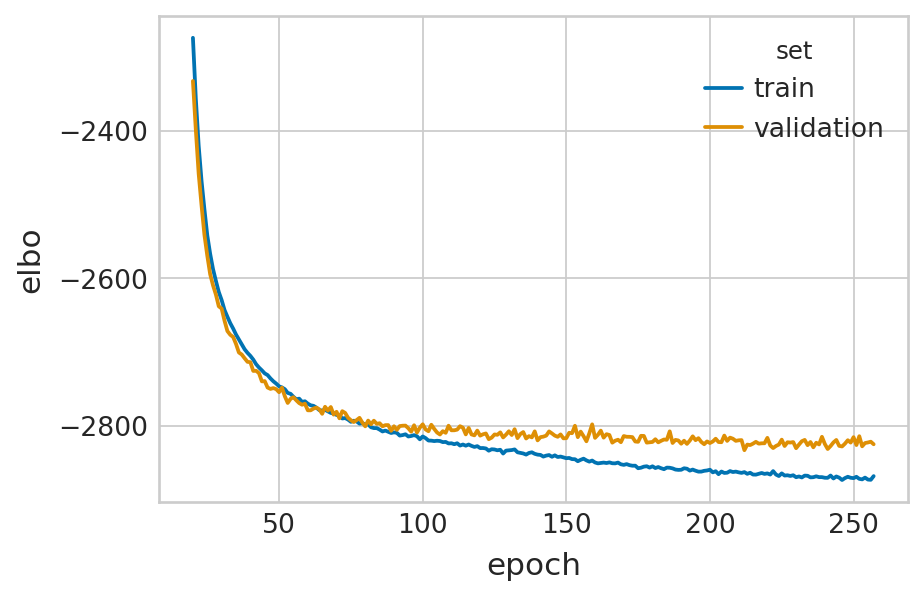

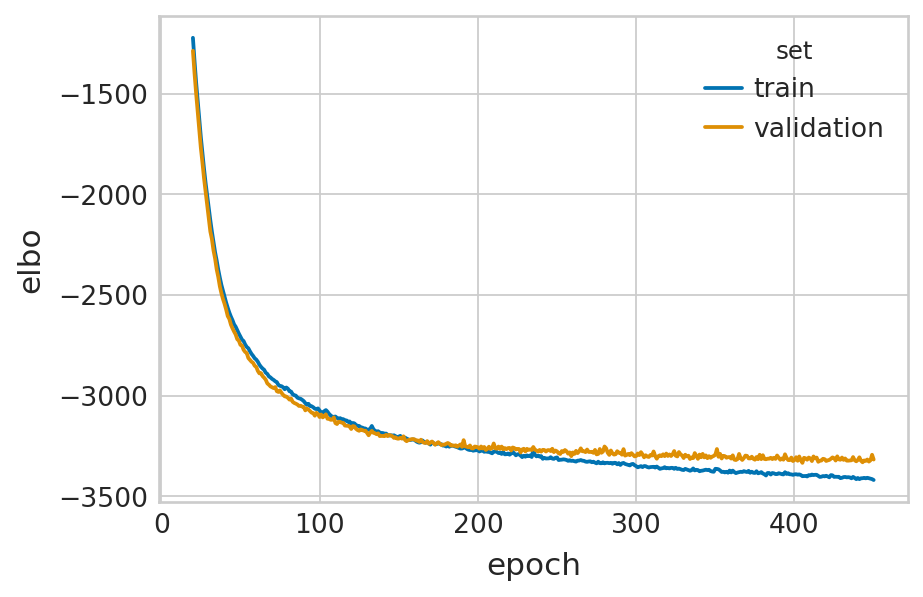

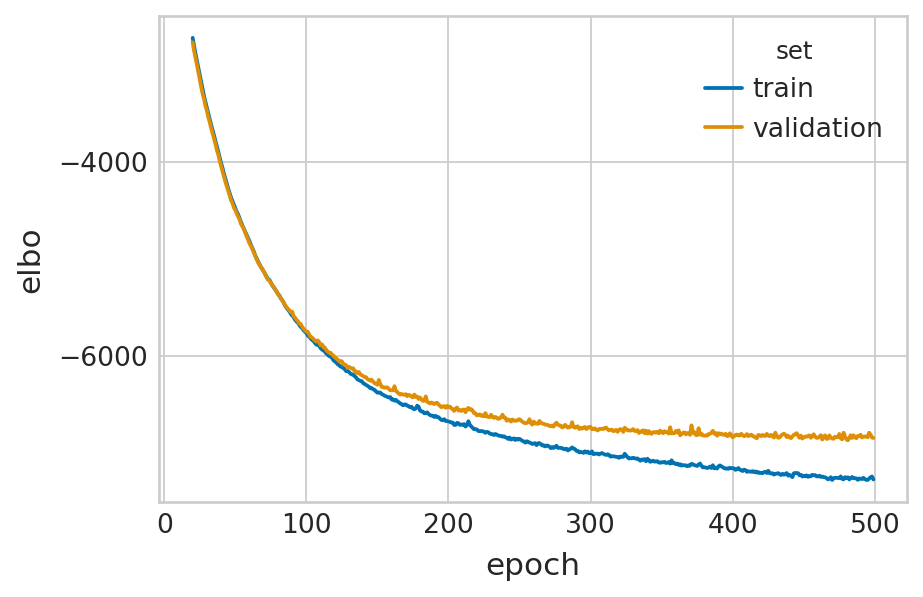

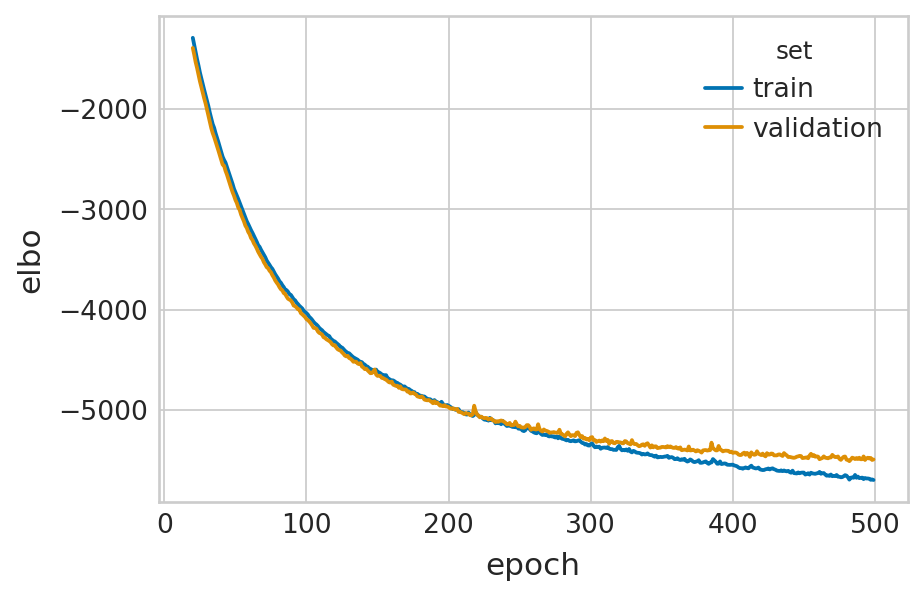

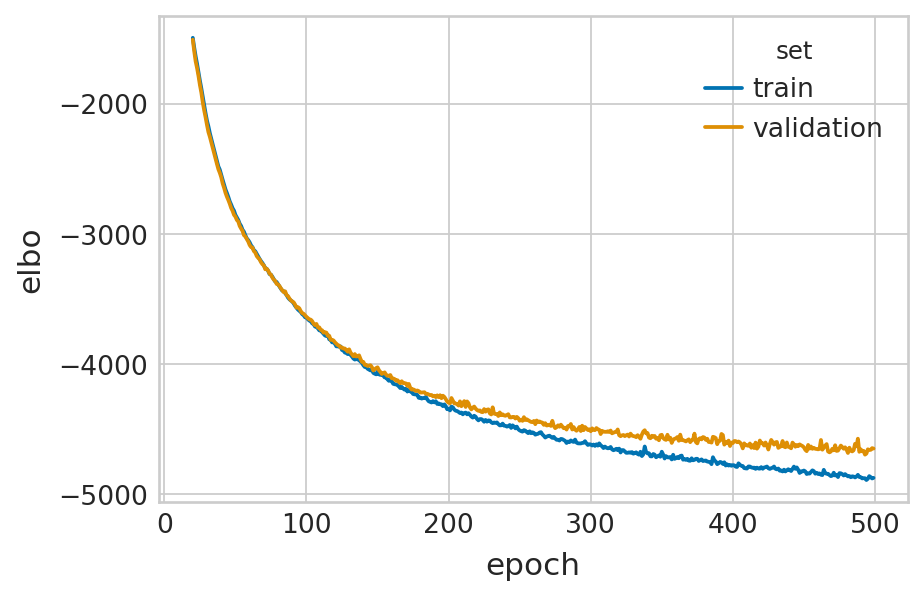

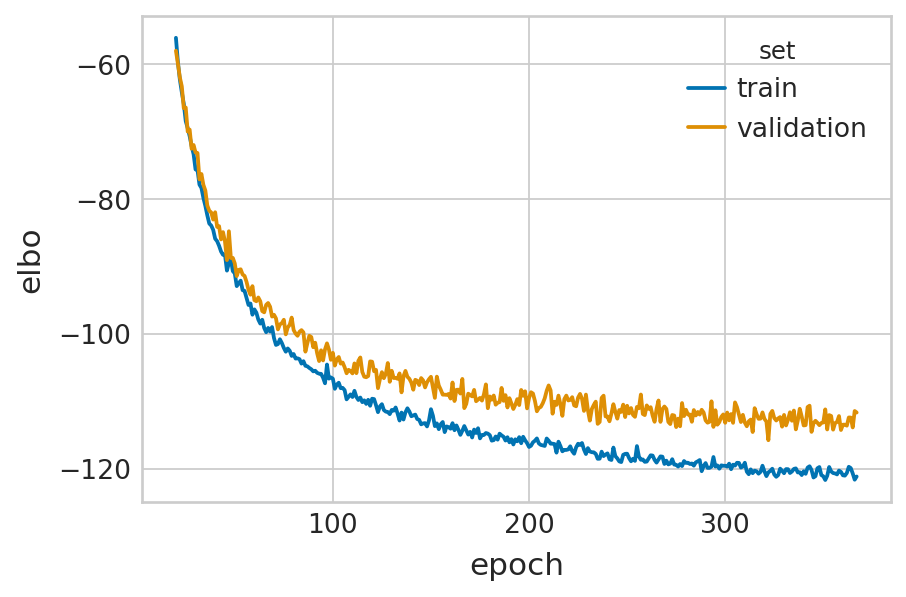

In [13]:
velovi_vaes = []
for a, n in zip(adatas, names):
    velovi_vaes.append(fit_velovi(a))

## Evaluate

### Permutation

In [14]:
perm_scores = {}
perm_datas = {}
for a, n, v, l in zip(adatas, names, velovi_vaes, labels_keys):
    perm_scores[n], perm_datas[n] = v.get_permutation_scores(labels_key=l)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

In [15]:
full_perm_df = pd.DataFrame(columns=["Score", "Dataset"])
scores = []
dataset = []
for n, p in perm_scores.items():
    p = p.values
    max_ratio = np.nanmax(p, axis=1)
    scores += max_ratio.tolist()
    dataset += [n] * len(max_ratio)
full_perm_df["Score"] = scores
full_perm_df["Dataset"] = dataset

In [16]:
datasets = ['Simulated', 'PBMC', 'PFC', 'Old brain', 'Mouse retina', 'Forebrain', 'Hippocampus', 'Spermatogenesis', 'Pancreas']
n_datasets = len(datasets)

full_perm_df['Dataset_id'] = full_perm_df['Dataset'].replace(
    dict(zip(datasets, range(len(datasets))))
)

palette = dict(zip(full_perm_df['Dataset'].unique(), sns.color_palette('colorblind').as_hex()[:n_datasets]))

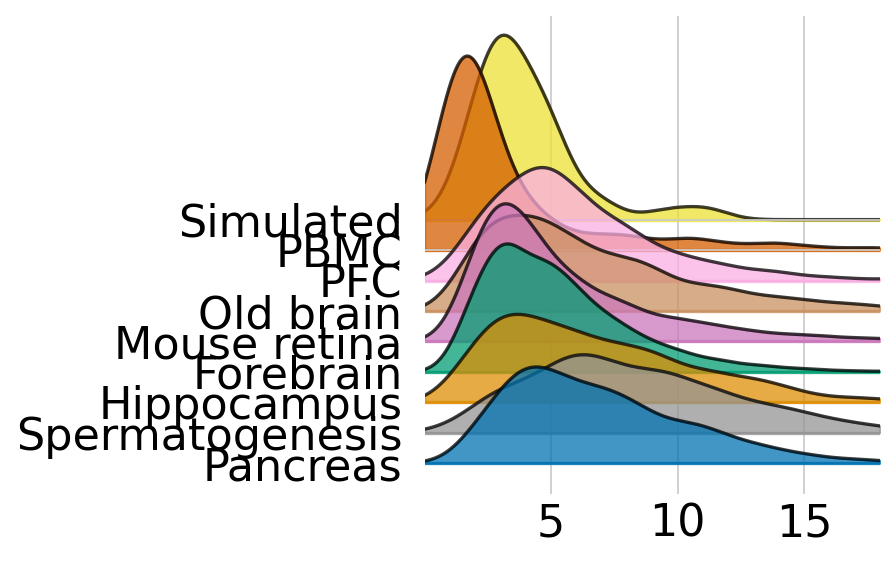

In [17]:
fig, axes = joypy.joyplot(
    full_perm_df,
    by='Dataset_id',
    color=[palette[dataset] for dataset in datasets],
    alpha=0.75,
    labels=datasets,
    x_range=[0, 18],
    figsize=(6, 4),
    grid='both'
)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'permutation' / 'permutation_score_densities.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [18]:
datasets = full_perm_df["Dataset"].unique()
dataset_dataset_df = pd.DataFrame(
    index=datasets, columns=datasets, data=np.zeros((len(datasets), len(datasets)))
)
features = ["Skew", "Kurtosis"]

data_stats_df = pd.DataFrame(
    index=datasets,
    columns=features,
    data=np.zeros(
        (len(datasets), len(features))
    )
)

In [19]:
for d in tqdm(datasets):
    score1 = full_perm_df.query("Dataset == @d")["Score"]
    score1 = score1[score1 <= np.percentile(score1, 99)]
    data_stats_df.loc[d, "Skew"] = stats.skew(score1)
    data_stats_df.loc[d, "Kurtosis"] = stats.kurtosis(score1)
    
    for d_ in datasets:
        score2 = full_perm_df.query("Dataset == @d_")["Score"]
        dataset_dataset_df.loc[d, d_] = stats.wasserstein_distance(score1, score2)

100%|██████████| 9/9 [00:00<00:00, 50.81it/s]


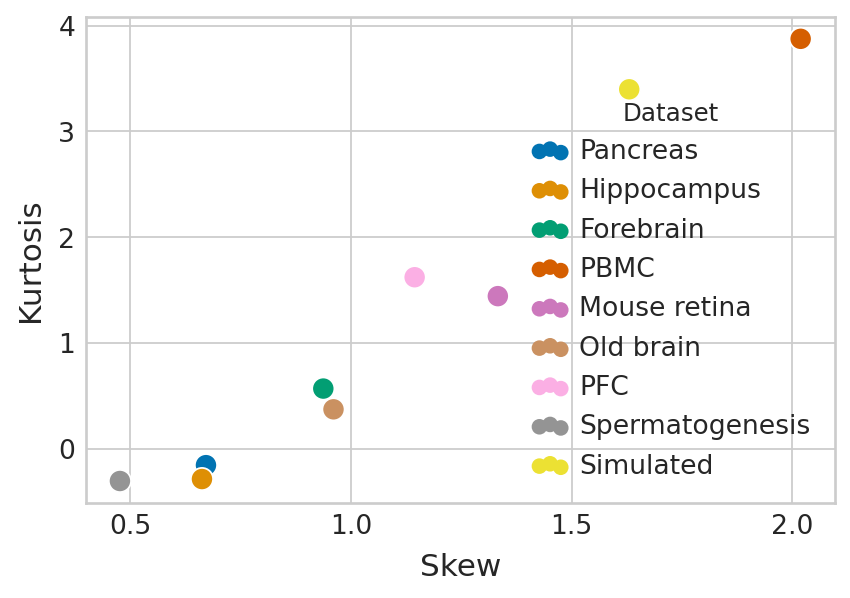

In [20]:
data_stats_df = data_stats_df.reset_index().rename(columns={'index': 'Dataset'})
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=data_stats_df,
        x="Skew",
        y="Kurtosis",
        hue="Dataset",
        s=100,
        palette='colorblind',
        ax=ax,
    )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'permutation' / 'permutation_score_density_kurtosis_vs_skew.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight',
    )

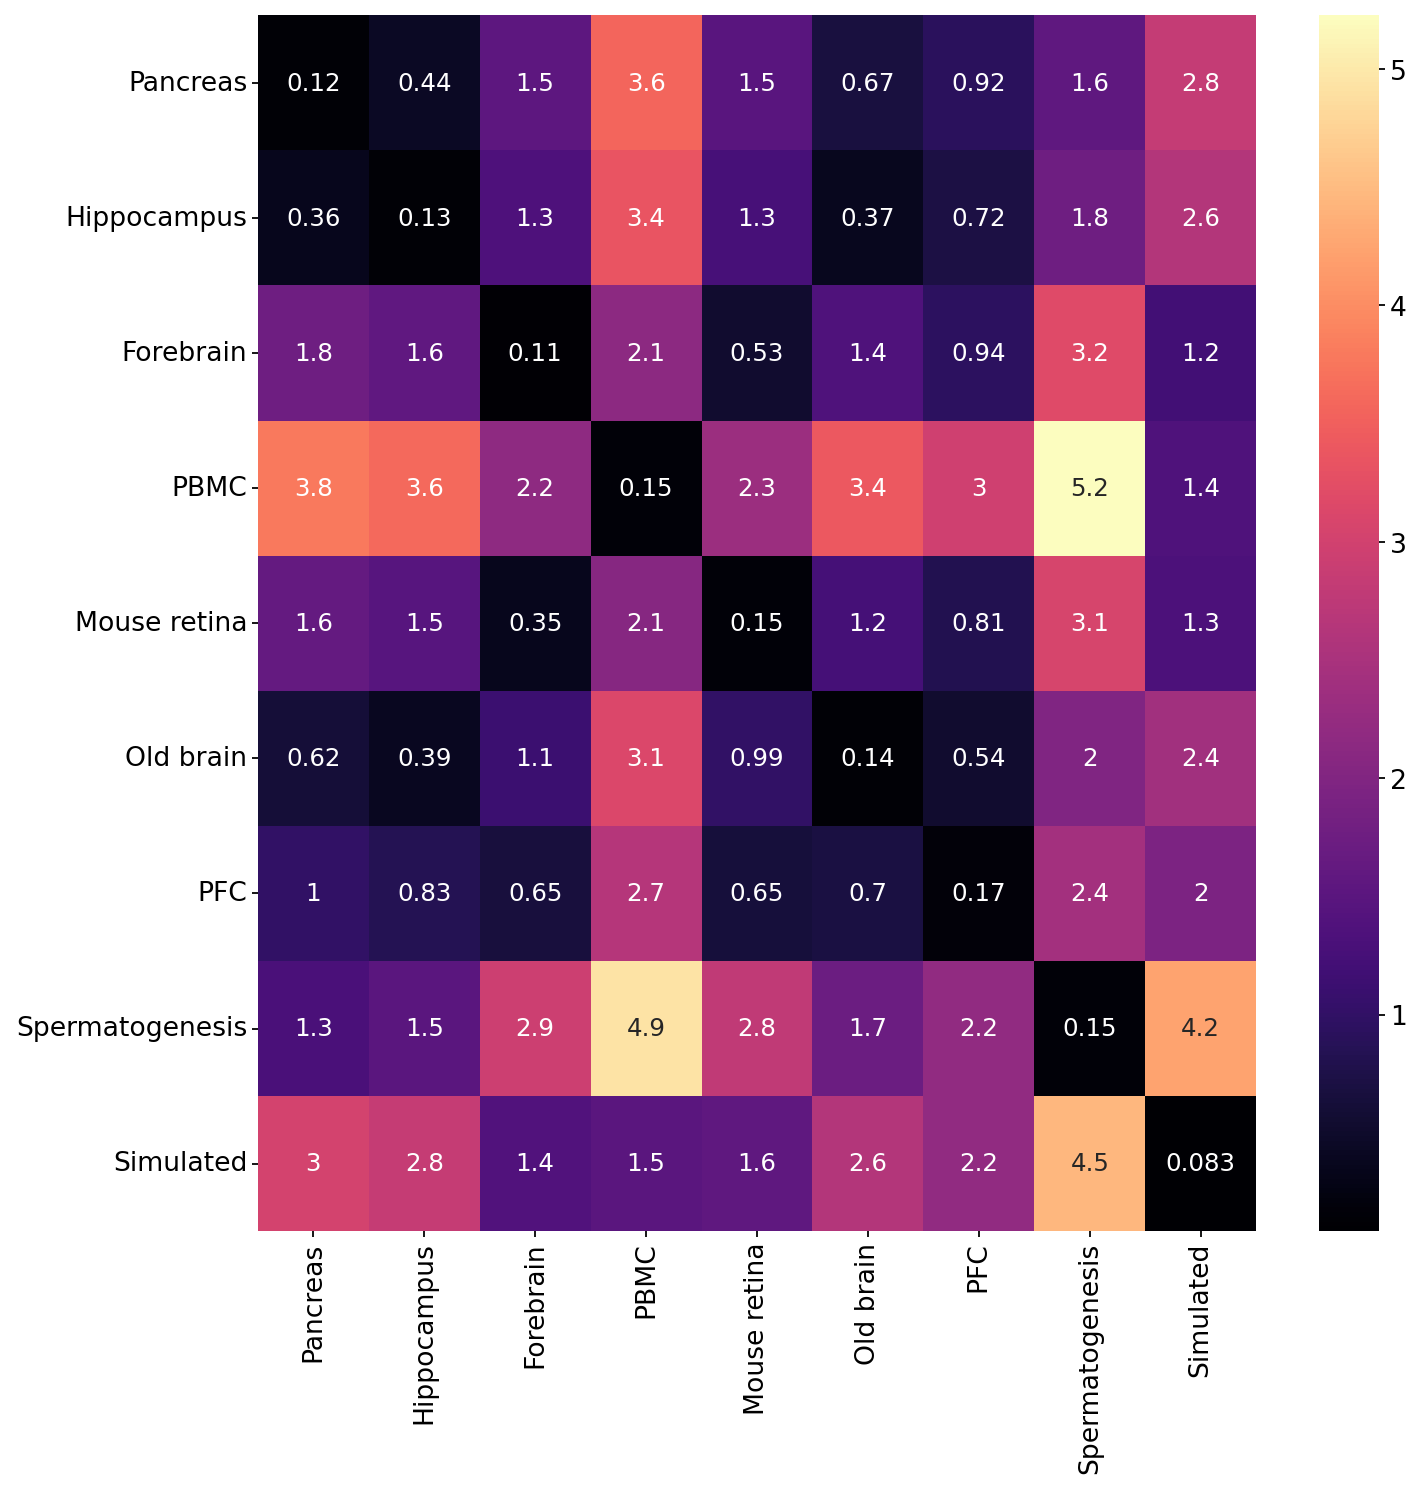

In [21]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(dataset_dataset_df, cmap="magma", annot=True, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'permutation' / 'permutation_score_wasserstein_heatmap.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight',
    )

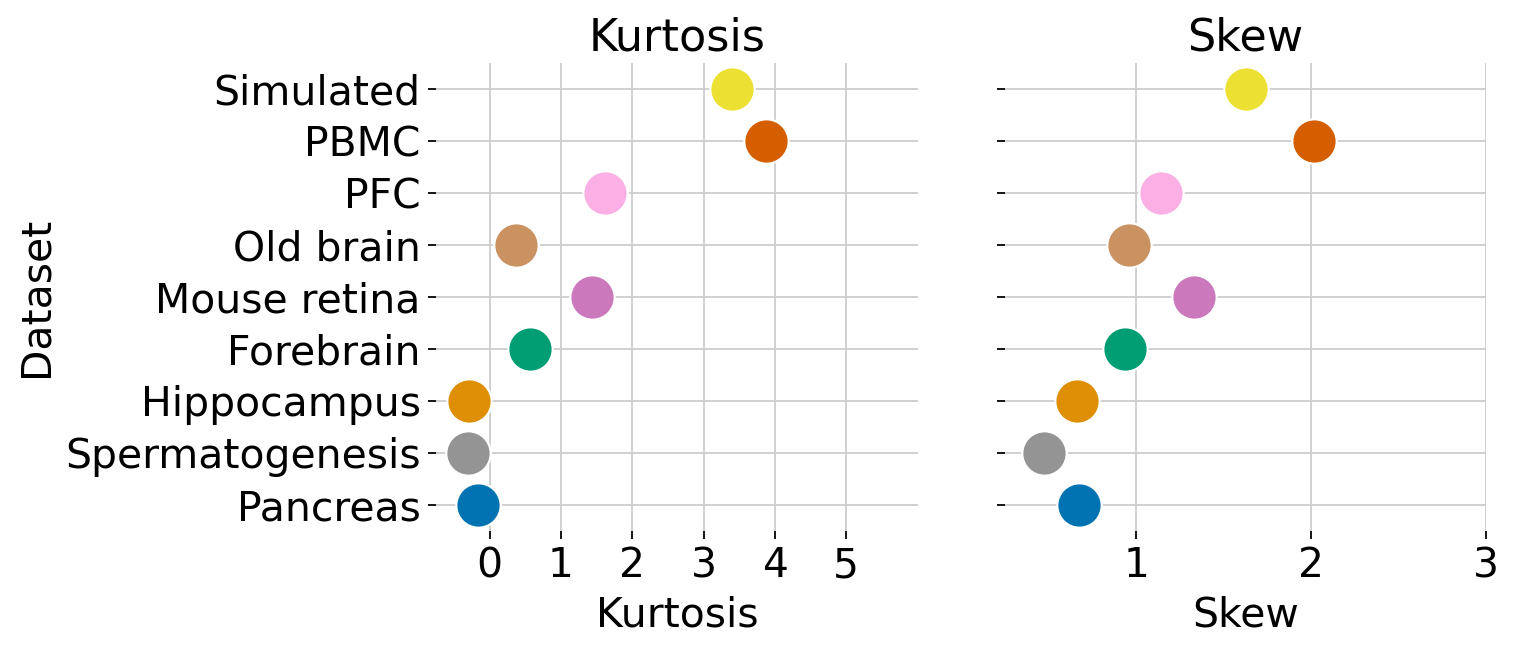

In [22]:
datasets = ['Simulated', 'PBMC', 'PFC', 'Old brain', 'Mouse retina', 'Forebrain', 'Hippocampus', 'Spermatogenesis', 'Pancreas']
_df = data_stats_df.set_index('Dataset').loc[datasets, :].reset_index()
g = sns.PairGrid(
    _df,
    x_vars=['Kurtosis', 'Skew'],
    y_vars=["Dataset"],
    height=4,
)

g.map(
    sns.stripplot,
    size=20,
    orient="h",
    jitter=False,
    palette=palette,
    linewidth=1,
    edgecolor="w"
)

titles = ['Kurtosis', 'Skew']
xlims = [(-0.75, 6), (0.25, 3)]

for ax, title, xlim in zip(g.axes.flat, titles, xlims):
    ax.set(title=title)
    ax.set_xlim(xlim)

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

g.axes.flat[0].set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(left=True, bottom=True)

if SAVE_FIGURES:
    g.savefig(
        FIG_DIR / 'permutation' / 'permutation_density_statistics.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight',
    )